In [2]:
import json
with open(r"D:\software\github\GZK_Code\XAI\2022.02.16\answers copy.txt",  "r")as f:
    json_strs = f.readlines()
#删除所有的空行
for json_str in json_strs:
    if json_str == '\n':
        json_strs.remove(json_str)

data = []
for i in json_strs:
    data.append(json.loads(i))




def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)

    return 2 * (prec * rec) / (prec + rec)




"""
原模型准确率
"""
acc = 0
temp = 0
for i in range(4141):
    f1 = 0
    f1 = compute_f1(data[i]["answer"], data[i]["preds"][0])
    acc += f1
    temp +=1
print("原模型准确率", acc/temp)

"""只根据atribution得准确率"""
bestanswer_ids = []
for i in data:
    bestanswer_ids.append(i["attributions"].index(max(i["attributions"])))

acc = 0
temp = 0
for i in range(4141):
    f1 = 0
    f1 = compute_f1(data[i]["answer"], data[i]["preds"][bestanswer_ids[i]])
    acc += f1
    temp +=1
print("只根据atribution得准确率", acc/temp)


"""只根据atribution+attentions准确率"""
bestanswer_ids = []
aa_acore = []
for i in data:
    aa_acore = [i["attributions"][aa] + i["start_score"][aa] + i["end_score"][aa] for aa in range(len(i["attributions"]))]
    bestanswer_ids.append(aa_acore.index(max(aa_acore)))

acc = 0
temp = 0
for i in range(4141):
    f1 = 0
    f1 = compute_f1(data[i]["answer"], data[i]["preds"][bestanswer_ids[i]])
    acc += f1
    temp +=1
print("只根据atribution+attentions准确率", acc/temp)
"""最好的准确率"""
acc = 0
temp = 0
best_f1_index = []
for i in range(4141):
    f1 = []
    #f1 = compute_f1(data[i]["answer"], data[i]["preds"][0])
    for pred in data[i]["preds"]:
        f1.append(compute_f1(data[i]["answer"], pred))
    acc += max(f1)
    temp +=1
    best_f1_index.append(f1.index(max(f1)))
print("最好的准确率", acc/temp)


原模型准确率 0.6572873952458597
只根据atribution得准确率 0.4807495189522721
只根据atribution+attentions准确率 0.5260020358016114
最好的准确率 0.6939309817043057


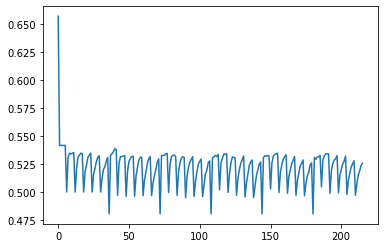

In [3]:
import numpy as np
import matplotlib.pyplot as plt
xs =  np.linspace(0,2, 6)
ys =  np.linspace(0,2, 6)
zs =  np.linspace(0,2, 6)
thresholds = []
Accurates = []
for x in range(len(xs)):
    for y in range(len(ys)):
        for z in range(len(zs)):
            temp0 = xs[x]
            temp1 = ys[y]
            temp2 = zs[z]
            thresholds.append([temp0, temp1, temp2])

def computer_ths_acc(threshold):
    bestanswer_ids = []
    aa_acore = []
    for i in data:
        aa_acore = [i["attributions"][aa]*threshold[0] + i["start_score"][aa]*threshold[1] + i["end_score"][aa]*threshold[2] for aa in
                    range(len(i["attributions"]))]
        bestanswer_ids.append(aa_acore.index(max(aa_acore)))

    acc = 0
    temp = 0
    for i in range(4141):
        f1 = 0
        f1 = compute_f1(data[i]["answer"], data[i]["preds"][bestanswer_ids[i]])
        acc += f1
        temp += 1
    #print("只根据atribution+attentions准确率", acc / temp)
    Accurates.append(acc / temp)
    return acc / temp





"""不同权重的atribution+attentions准确率"""
for threshold in range(len(thresholds)):
    #print(thresholds[threshold])
    computer_ths_acc(thresholds[threshold])


plt.plot(range(len(thresholds)), Accurates)

In [19]:
a = computer_ths_acc([0.0, 0.0, 0.0])


In [7]:
xs =  np.linspace(0,2, 21)
ys =  np.linspace(0,2, 21)
zs =  np.linspace(0,2, 21)
wights = []
Accurates = []
for x in range(len(xs)):
    for y in range(len(ys)):
        for z in range(len(zs)):
            temp0 = xs[x]
            temp1 = ys[y]
            temp2 = zs[z]
            wights.append([temp0, temp1, temp2])
print("number of wights", len(wights))

number of wights 9261


## 模型预测

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.autograd import Variable

# make fake data
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

target:  341 train :  338
target:  <class 'list'> train :  <class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([338, 2]) torch.Size([338])
Sequential(
  (0): Linear(in_features=2, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=32, bias=True)
)
0.008875739644970414


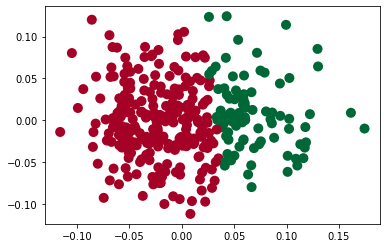

0.27514792899408286


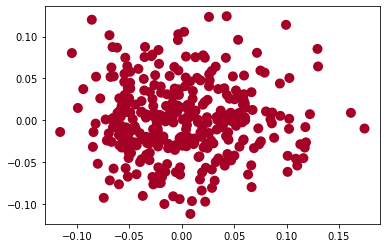

0.27514792899408286


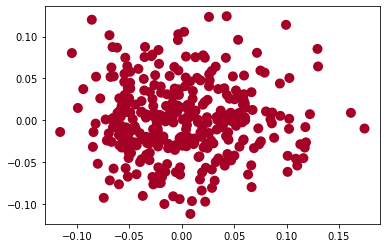

0.27514792899408286


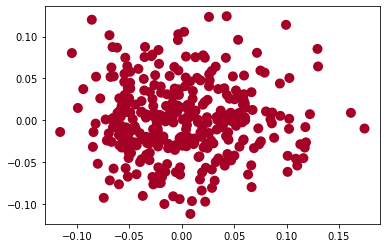

0.27514792899408286


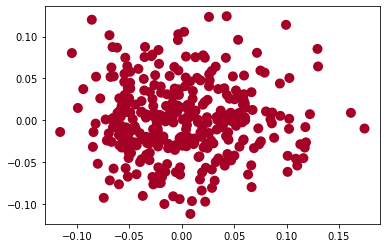

0.27514792899408286


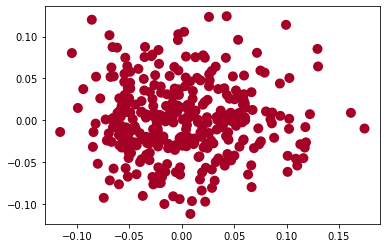

0.27514792899408286


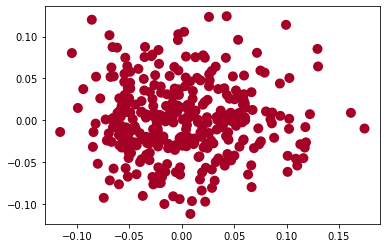

0.27514792899408286


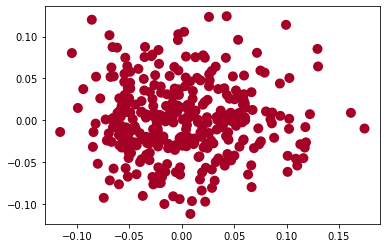

0.27514792899408286


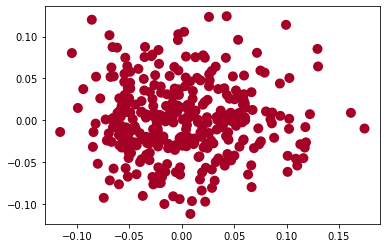

0.27514792899408286


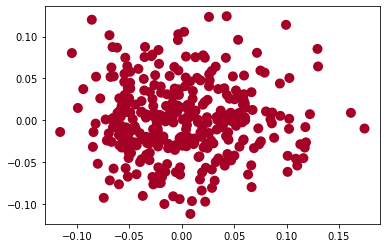

0.27514792899408286


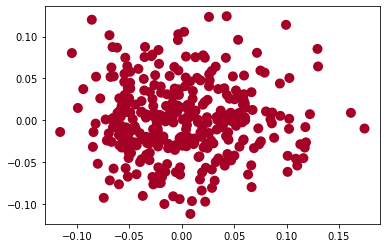

0.27514792899408286


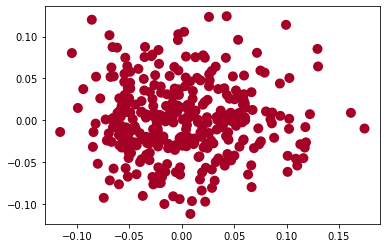

0.27514792899408286


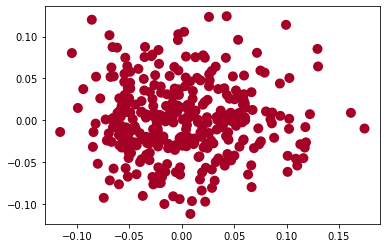

0.27514792899408286


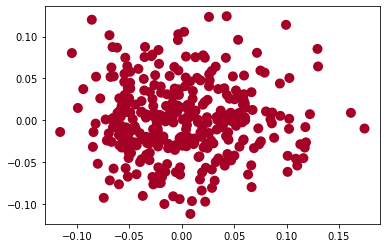

0.27514792899408286


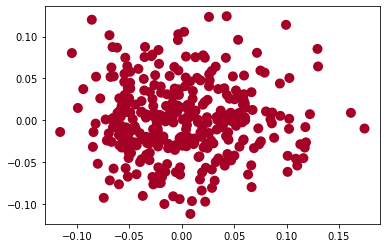

In [9]:


target = []
# best_f1_index = []   # 已经有了
train = []
"""先把不是第0个最好结果的提出来"""
for i in range(4141):
    """首先提出最好的f1的index"""
    if best_f1_index[i] != 0:
        target.append(best_f1_index[i])
        train.append(data[i]["attributions"])
for i in range(len(train)):
    if i == 162:
        pass
    if len(train[i]) < 14:
        add_list = [0 for i in range(32 - len(train[i]))]
        train[i] = train[i] + add_list
zip_train = []
zip_target = []
for i in range(len(train)):
    if len(train[i]) == 32:
        zip_train.append(train[i])
        zip_target.append(target[i])


array_train = np.array(zip_train)
array_target = np.array(zip_target)
print("target: " , len(target), "train : ", len(array_train))
print("target: " , type(target), "train : ", type(array_target))
# 特征降维——主成分分析
transfer_1 = PCA(n_components=2)
train = torch.from_numpy(np.array(array_train))
print(type(train))
train = transfer_1.fit_transform(array_train)
x = torch.from_numpy(train)
y = torch.from_numpy(array_target)
print(type(x), type(y))
x, y = Variable(x), Variable(y)
print(x.shape, y.shape)

# mehod
net = torch.nn.Sequential(
    torch.nn.Linear(2, 500),
    torch.nn.ReLU(),
    torch.nn.Linear(500, 32),
)
# net1 = Net(n_feature=2, n_hidden=10, n_output=3)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.2)  # 随机梯度下降
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

for t in range(150):
    out = net(x.float())  # input x and predict based on x
    loss = loss_func(out, y.long())  # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()  # clear gradients for next train
    loss.backward()  # backpropagation, compute gradients
    optimizer.step()  # apply gradients

    if t % 10 == 0:
        # plot and show learning process
        plt.cla()
        prediction = torch.max(out, 1)[1]
        pred_y = prediction.data.numpy()
        target_y = y.data.numpy()
        plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = float((pred_y == target_y).astype(int).sum()) / float(target_y.size)
        print(accuracy)

        plt.pause(0.1)

plt.show()
# torch.save(net, 'net.pkl')  # save entire net


target:  341 train :  69
target:  <class 'list'> train :  <class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([69, 2]) torch.Size([69])
Sequential(
  (0): Linear(in_features=2, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=32, bias=True)
)
0.0


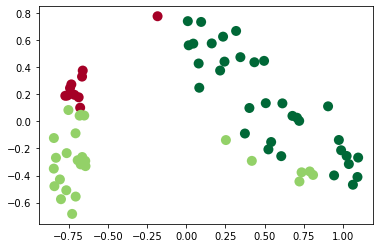

0.391304347826087


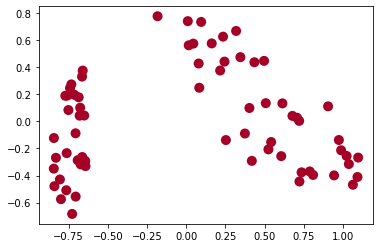

0.43478260869565216


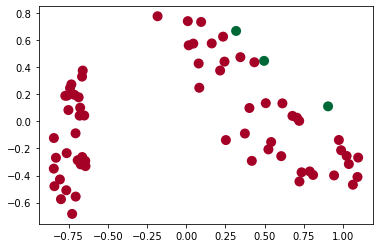

0.4492753623188406


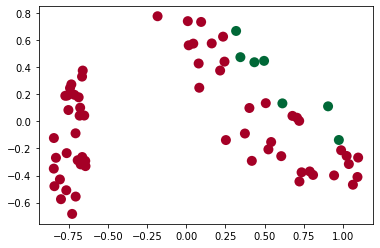

0.463768115942029


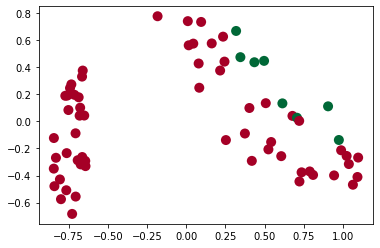

0.4492753623188406


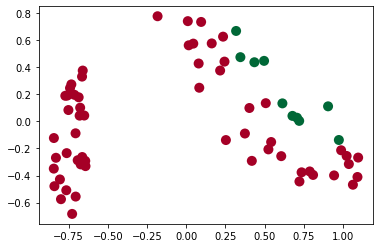

0.4492753623188406


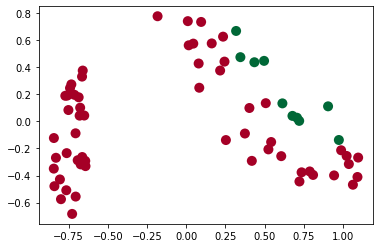

0.4492753623188406


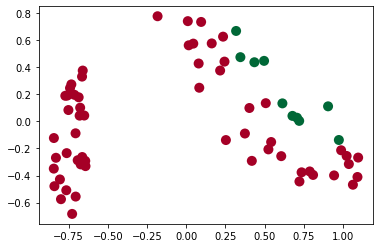

0.4492753623188406


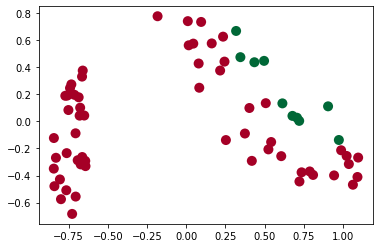

0.43478260869565216


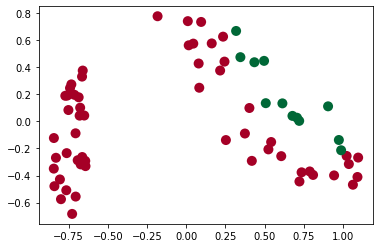

0.43478260869565216


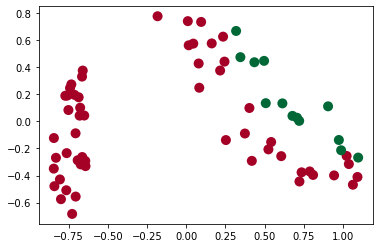

0.43478260869565216


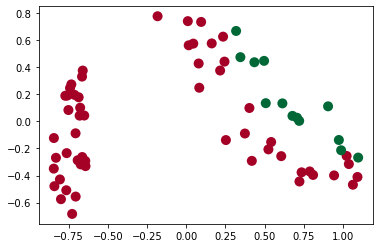

0.4492753623188406


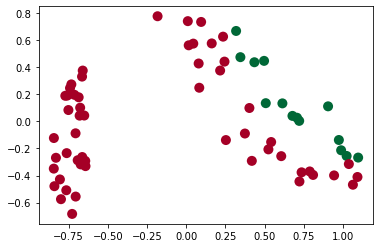

0.4492753623188406


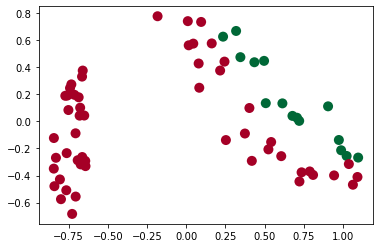

0.4492753623188406


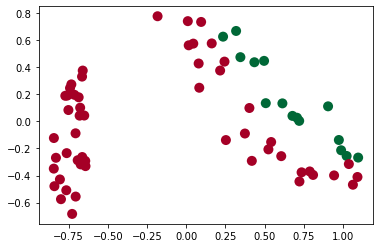

In [11]:


target = []
# best_f1_index = []   # 已经有了
train = []
"""先把不是第0个最好结果的提出来"""
for i in range(4141):
    """首先提出最好的f1的index"""
    if best_f1_index[i] != 0:
        target.append(best_f1_index[i])
        train.append(data[i]["attributions"] + data[i]["start_score"] + data[i]["end_score"])
for i in range(len(train)):
    if i == 162:
        pass
    if len(train[i]) < 14:
        add_list = [0 for i in range(32 - len(train[i]))]
        train[i] = train[i] + add_list
zip_train = []
zip_target = []
for i in range(len(train)):
    if len(train[i]) == 32:
        zip_train.append(train[i])
        zip_target.append(target[i])


array_train = np.array(zip_train)
array_target = np.array(zip_target)
print("target: " , len(target), "train : ", len(array_train))
print("target: " , type(target), "train : ", type(array_target))
# 特征降维——主成分分析
transfer_1 = PCA(n_components=2)
train = torch.from_numpy(np.array(array_train))
print(type(train))
train = transfer_1.fit_transform(array_train)
x = torch.from_numpy(train)
y = torch.from_numpy(array_target)
print(type(x), type(y))
x, y = Variable(x), Variable(y)
print(x.shape, y.shape)


# mehod
net = torch.nn.Sequential(
    torch.nn.Linear(2, 500),
    torch.nn.ReLU(),
    torch.nn.Linear(500, 32),
)
# net1 = Net(n_feature=2, n_hidden=10, n_output=3)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.2)  # 随机梯度下降
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

for t in range(150):
    out = net(x.float())  # input x and predict based on x
    loss = loss_func(out, y.long())  # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()  # clear gradients for next train
    loss.backward()  # backpropagation, compute gradients
    optimizer.step()  # apply gradients

    if t % 10 == 0:
        # plot and show learning process
        plt.cla()
        prediction = torch.max(out, 1)[1]
        pred_y = prediction.data.numpy()
        target_y = y.data.numpy()
        plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = float((pred_y == target_y).astype(int).sum()) / float(target_y.size)
        print(accuracy)

        plt.pause(0.1)

plt.show()
# torch.save(net, 'net.pkl')  # save entire net

target:  341 train :  228
target:  <class 'list'> train :  <class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([228, 2]) torch.Size([228])
Sequential(
  (0): Linear(in_features=2, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=32, bias=True)
)
0.0


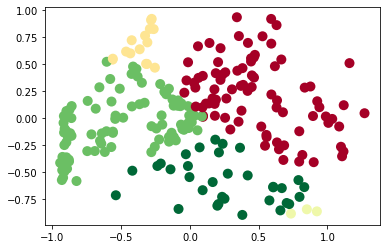

0.32894736842105265


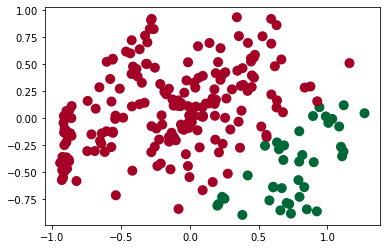

0.32894736842105265


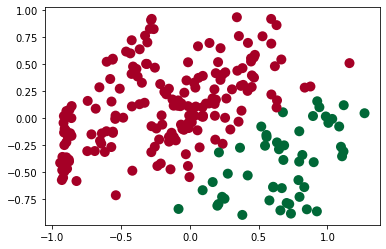

0.32456140350877194


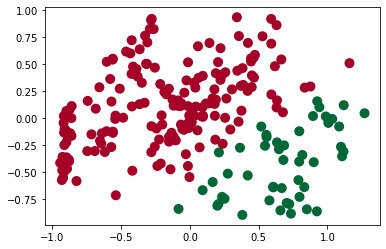

0.32456140350877194


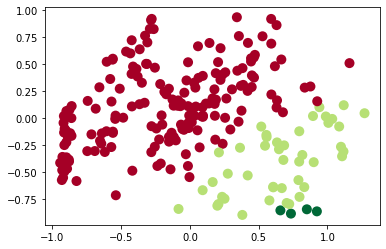

0.32456140350877194


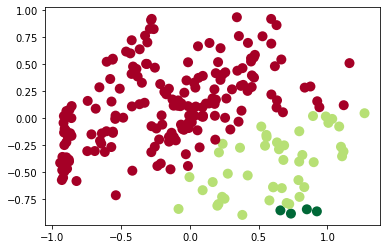

0.3333333333333333


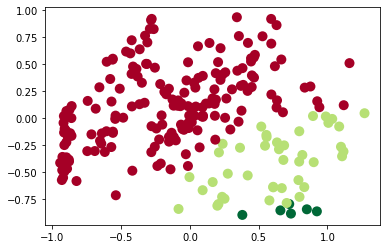

0.32894736842105265


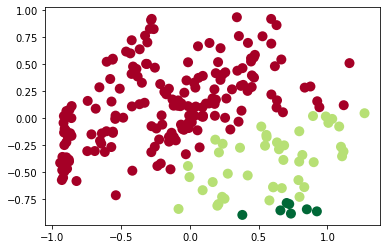

0.32456140350877194


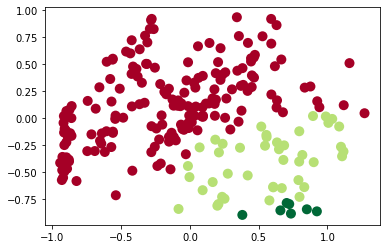

0.3201754385964912


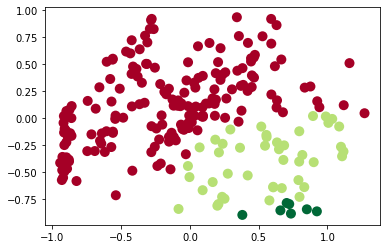

0.3201754385964912


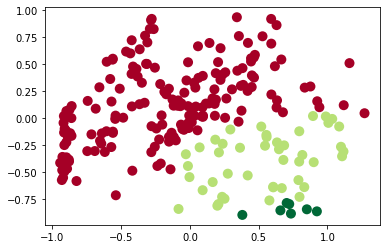

0.3157894736842105


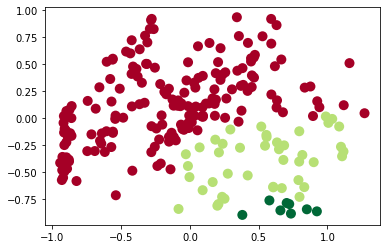

0.3157894736842105


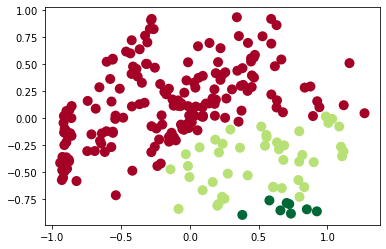

0.3157894736842105


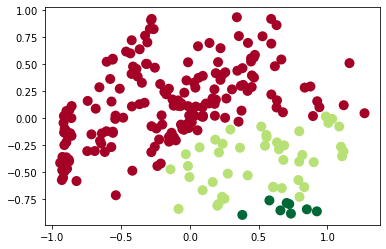

0.3201754385964912


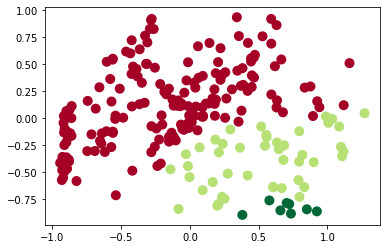

In [12]:


target = []
# best_f1_index = []   # 已经有了
train = []
"""先把不是第0个最好结果的提出来"""
for i in range(4141):
    """首先提出最好的f1的index"""
    if best_f1_index[i] != 0:
        target.append(best_f1_index[i])
        train.append( data[i]["start_score"] + data[i]["end_score"])
for i in range(len(train)):
    if i == 162:
        pass
    if len(train[i]) < 14:
        add_list = [0 for i in range(32 - len(train[i]))]
        train[i] = train[i] + add_list
zip_train = []
zip_target = []
for i in range(len(train)):
    if len(train[i]) == 32:
        zip_train.append(train[i])
        zip_target.append(target[i])


array_train = np.array(zip_train)
array_target = np.array(zip_target)
print("target: " , len(target), "train : ", len(array_train))
print("target: " , type(target), "train : ", type(array_target))
# 特征降维——主成分分析
transfer_1 = PCA(n_components=2)
train = torch.from_numpy(np.array(array_train))
print(type(train))
train = transfer_1.fit_transform(array_train)
x = torch.from_numpy(train)
y = torch.from_numpy(array_target)
print(type(x), type(y))
x, y = Variable(x), Variable(y)
print(x.shape, y.shape)


# mehod
net = torch.nn.Sequential(
    torch.nn.Linear(2, 500),
    torch.nn.ReLU(),
    torch.nn.Linear(500, 32),
)
# net1 = Net(n_feature=2, n_hidden=10, n_output=3)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.2)  # 随机梯度下降
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

for t in range(150):
    out = net(x.float())  # input x and predict based on x
    loss = loss_func(out, y.long())  # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()  # clear gradients for next train
    loss.backward()  # backpropagation, compute gradients
    optimizer.step()  # apply gradients

    if t % 10 == 0:
        # plot and show learning process
        plt.cla()
        prediction = torch.max(out, 1)[1]
        pred_y = prediction.data.numpy()
        target_y = y.data.numpy()
        plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = float((pred_y == target_y).astype(int).sum()) / float(target_y.size)
        print(accuracy)

        plt.pause(0.1)

plt.show()
# torch.save(net, 'net.pkl')  # save entire net

target:  341 train :  228
target:  <class 'list'> train :  <class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([228, 2]) torch.Size([228])
Sequential(
  (0): Linear(in_features=2, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=32, bias=True)
)
0.017543859649122806


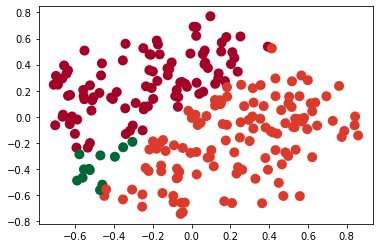

0.31140350877192985


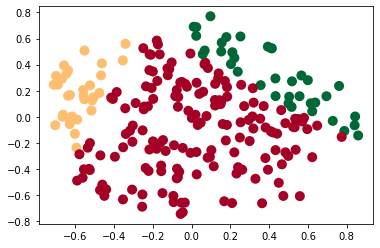

0.31140350877192985


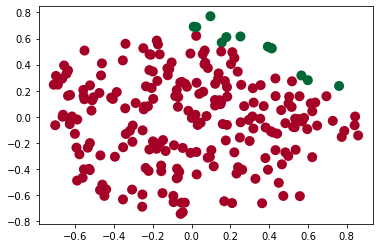

0.3157894736842105


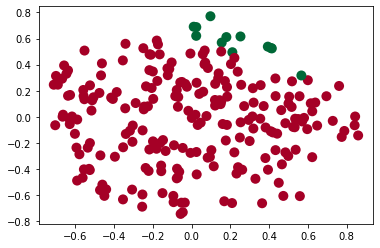

0.3201754385964912


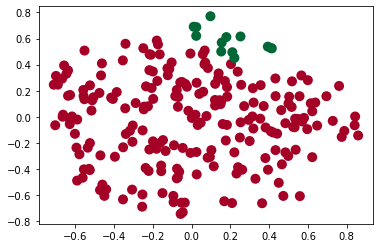

0.3201754385964912


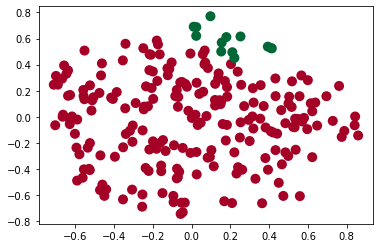

0.32456140350877194


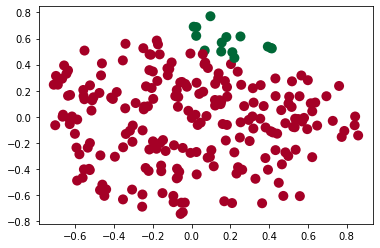

0.3201754385964912


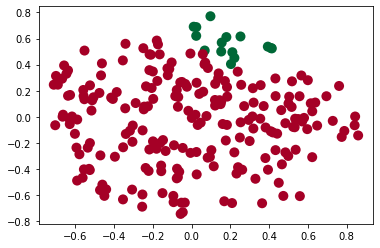

0.3201754385964912


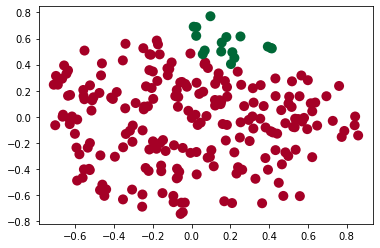

0.3201754385964912


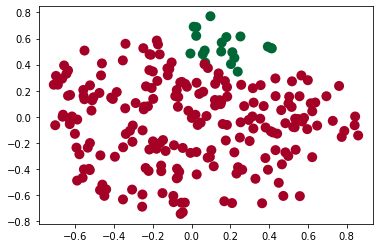

0.3201754385964912


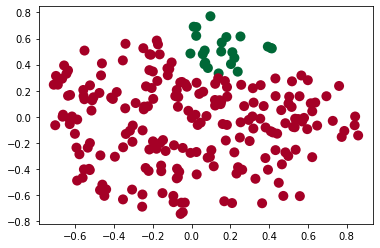

0.3157894736842105


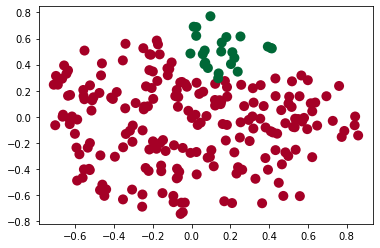

0.3201754385964912


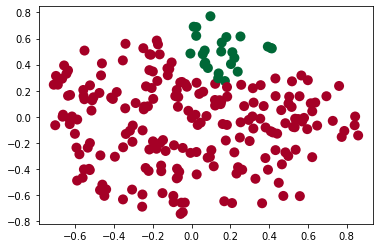

0.3201754385964912


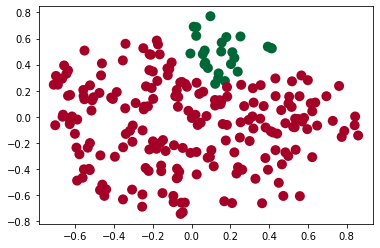

0.32456140350877194


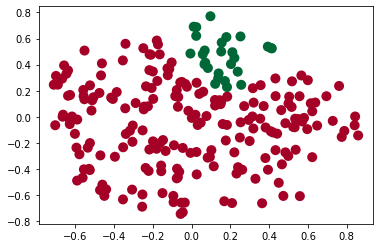

In [13]:


target = []
# best_f1_index = []   # 已经有了
train = []
"""先把不是第0个最好结果的提出来"""
for i in range(4141):
    """首先提出最好的f1的index"""
    if best_f1_index[i] != 0:
        target.append(best_f1_index[i])
        train.append( data[i]["start_score"] + data[i]["attributions"])
for i in range(len(train)):
    if i == 162:
        pass
    if len(train[i]) < 14:
        add_list = [0 for i in range(32 - len(train[i]))]
        train[i] = train[i] + add_list
zip_train = []
zip_target = []
for i in range(len(train)):
    if len(train[i]) == 32:
        zip_train.append(train[i])
        zip_target.append(target[i])


array_train = np.array(zip_train)
array_target = np.array(zip_target)
print("target: " , len(target), "train : ", len(array_train))
print("target: " , type(target), "train : ", type(array_target))
# 特征降维——主成分分析
transfer_1 = PCA(n_components=2)
train = torch.from_numpy(np.array(array_train))
print(type(train))
train = transfer_1.fit_transform(array_train)
x = torch.from_numpy(train)
y = torch.from_numpy(array_target)
print(type(x), type(y))
x, y = Variable(x), Variable(y)
print(x.shape, y.shape)


# mehod
net = torch.nn.Sequential( 
    torch.nn.Linear(2, 500),
    torch.nn.ReLU(),
    torch.nn.Linear(500, 32),
)
# net1 = Net(n_feature=2, n_hidden=10, n_output=3)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.2)  # 随机梯度下降
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

for t in range(150):
    out = net(x.float())  # input x and predict based on x
    loss = loss_func(out, y.long())  # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()  # clear gradients for next train
    loss.backward()  # backpropagation, compute gradients
    optimizer.step()  # apply gradients

    if t % 10 == 0:
        # plot and show learning process
        plt.cla()
        prediction = torch.max(out, 1)[1]
        pred_y = prediction.data.numpy()
        target_y = y.data.numpy()
        plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = float((pred_y == target_y).astype(int).sum()) / float(target_y.size)
        print(accuracy)

        plt.pause(0.1)

plt.show()
# torch.save(net, 'net.pkl')  # save entire net

target:  341 train :  228
target:  <class 'list'> train :  <class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([228, 2]) torch.Size([228])
Sequential(
  (0): Linear(in_features=2, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=32, bias=True)
)
0.0


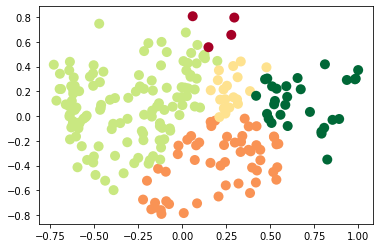

0.3508771929824561


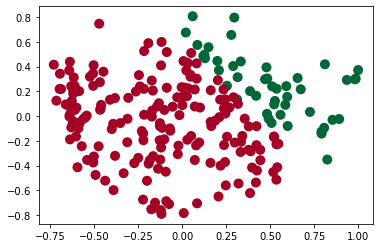

0.35964912280701755


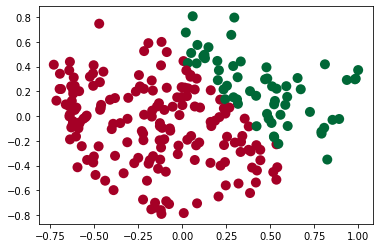

0.35964912280701755


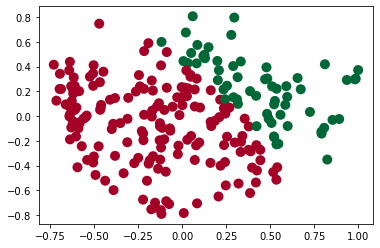

0.36403508771929827


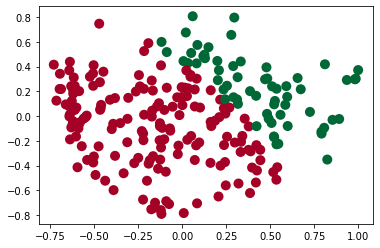

0.35526315789473684


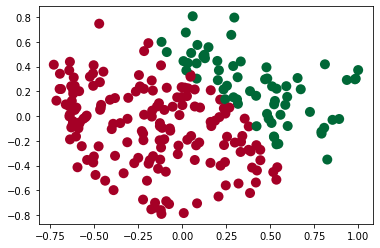

0.3508771929824561


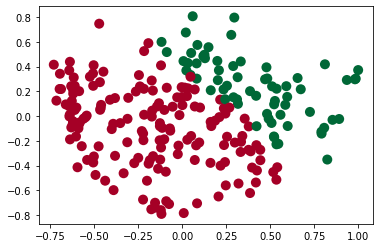

0.35526315789473684


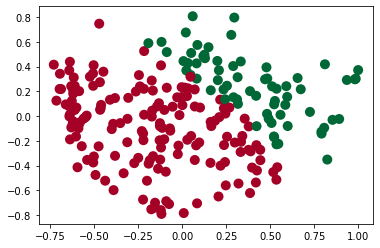

0.35526315789473684


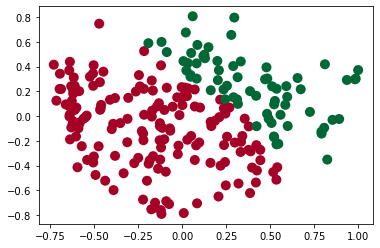

0.35526315789473684


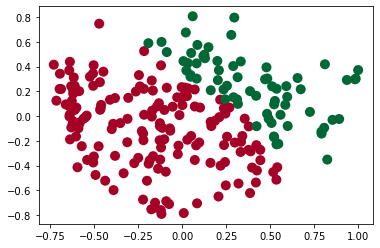

0.3508771929824561


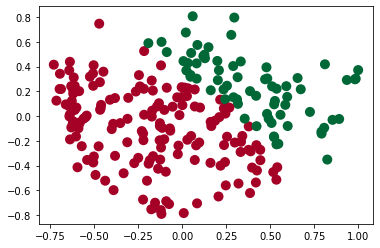

0.3508771929824561


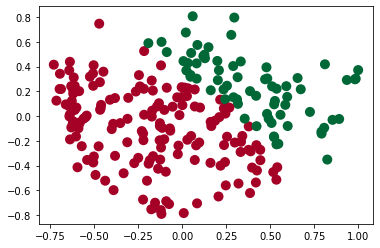

0.34649122807017546


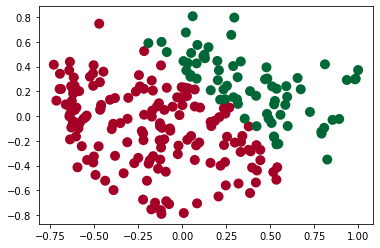

0.34649122807017546


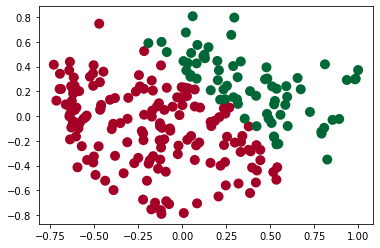

0.34210526315789475


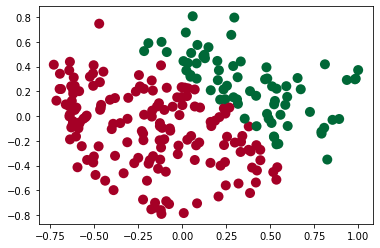

In [14]:


target = []
# best_f1_index = []   # 已经有了
train = []
"""先把不是第0个最好结果的提出来"""
for i in range(4141):
    """首先提出最好的f1的index"""
    if best_f1_index[i] != 0:
        target.append(best_f1_index[i])
        train.append( data[i]["end_score"] + data[i]["attributions"])
for i in range(len(train)):
    if i == 162:
        pass
    if len(train[i]) < 14:
        add_list = [0 for i in range(32 - len(train[i]))]
        train[i] = train[i] + add_list
zip_train = []
zip_target = []
for i in range(len(train)):
    if len(train[i]) == 32:
        zip_train.append(train[i])
        zip_target.append(target[i])


array_train = np.array(zip_train)
array_target = np.array(zip_target)
print("target: " , len(target), "train : ", len(array_train))
print("target: " , type(target), "train : ", type(array_target))
# 特征降维——主成分分析
transfer_1 = PCA(n_components=2)
train = torch.from_numpy(np.array(array_train))
print(type(train))
train = transfer_1.fit_transform(array_train)
x = torch.from_numpy(train)
y = torch.from_numpy(array_target)
print(type(x), type(y))
x, y = Variable(x), Variable(y)
print(x.shape, y.shape)


# mehod
net = torch.nn.Sequential(
    torch.nn.Linear(2, 500),
    torch.nn.ReLU(),
    torch.nn.Linear(500, 32),
)
# net1 = Net(n_feature=2, n_hidden=10, n_output=3)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.2)  # 随机梯度下降
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

for t in range(150):
    out = net(x.float())  # input x and predict based on x
    loss = loss_func(out, y.long())  # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()  # clear gradients for next train
    loss.backward()  # backpropagation, compute gradients
    optimizer.step()  # apply gradients

    if t % 10 == 0:
        # plot and show learning process
        plt.cla()
        prediction = torch.max(out, 1)[1]
        pred_y = prediction.data.numpy()
        target_y = y.data.numpy()
        plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = float((pred_y == target_y).astype(int).sum()) / float(target_y.size)
        print(accuracy)

        plt.pause(0.1)

plt.show()
# torch.save(net, 'net.pkl')  # save entire net

In [15]:
total = sum([param.nelement() for param in net.parameters()])

print("Number of parameter: %.2fM" % (total/1e6))

Number of parameter: 0.02M


In [ ]:


target = []
# best_f1_index = []   # 已经有了
train = []
"""先把不是第0个最好结果的提出来"""
for i in range(4141):
    """首先提出最好的f1的index"""
    if best_f1_index[i] != 0:
        target.append(best_f1_index[i])
        train.append( data[i]["end_score"] + data[i]["attributions"])
for i in range(len(train)):
    if i == 162:
        pass
    if len(train[i]) < 14:
        add_list = [0 for i in range(32 - len(train[i]))]
        train[i] = train[i] + add_list
zip_train = []
zip_target = []
for i in range(len(train)):
    if len(train[i]) == 32:
        zip_train.append(train[i])
        zip_target.append(target[i])


array_train = np.array(zip_train)
array_target = np.array(zip_target)
print("target: " , len(target), "train : ", len(array_train))
print("target: " , type(target), "train : ", type(array_target))
# 特征降维——主成分分析
transfer_1 = PCA(n_components=2)
train = torch.from_numpy(np.array(array_train))
print(type(train))
train = transfer_1.fit_transform(array_train)
x = torch.from_numpy(train)
y = torch.from_numpy(array_target)
print(type(x), type(y))
x, y = Variable(x), Variable(y)
print(x.shape, y.shape)


# mehod
net = torch.nn.Sequential(
    torch.nn.Linear(2, 500),
    torch.nn.ReLU(),
    torch.nn.Linear(500, 32),
)
# net1 = Net(n_feature=2, n_hidden=10, n_output=3)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.2)  # 随机梯度下降
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

for t in range(150):
    out = net(x.float())  # input x and predict based on x
    loss = loss_func(out, y.long())  # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()  # clear gradients for next train
    loss.backward()  # backpropagation, compute gradients
    optimizer.step()  # apply gradients

    if t % 10 == 0:
        # plot and show learning process
        plt.cla()
        prediction = torch.max(out, 1)[1]
        pred_y = prediction.data.numpy()
        target_y = y.data.numpy()
        plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = float((pred_y == target_y).astype(int).sum()) / float(target_y.size)
        print(accuracy)

        plt.pause(0.1)

plt.show()
# torch.save(net, 'net.pkl')  # save entire net

In [25]:

target = []
# best_f1_index = []   # 已经有了
train = []
"""先把不是第0个最好结果的提出来"""
for i in range(4141):
    """首先提出最好的f1的index"""
    if best_f1_index[i] != 0:
        target.append(best_f1_index[i])
        train.append( data[i]["attributions"])
# for i in range(len(train)):
#     if i == 162:
#         pass
#     if len(train[i]) < 14:
#         add_list = [0 for i in range(32 - len(train[i]))]
#         train[i] = train[i] + add_list
# zip_train = []
# zip_target = []
# for i in range(len(train)):
#     if len(train[i]) == 32:
#         zip_train.append(train[i])
#         zip_target.append(target[i])


# array_train = np.array(zip_train)
# array_target = np.array(zip_target)
# print("target: " , len(target), "train : ", len(array_train))
# print("target: " , type(target), "train : ", type(array_target))
# # 特征降维——主成分分析
# transfer_1 = PCA(n_components=2)
# train = torch.from_numpy(np.array(array_train))
# print(type(train))
# train = transfer_1.fit_transform(array_train)
# x = torch.from_numpy(train)
# y = torch.from_numpy(array_target)
# print(type(x), type(y))
# x, y = Variable(x), Variable(y)
# print(x.shape, y.shape)

In [26]:
train

[[-0.004047474135391173,
  0.0784472163088147,
  -0.013094592291189647,
  0.10931275253252441,
  -0.03921009408765239],
 [0.00015089406335905444,
  0.07044577494844909,
  0.000646355686580757,
  0.0636492221373145,
  0.03808073514855893],
 [0.002325448147963927,
  0.08105371911405967,
  0.03509999542130514,
  0.026855587792109663,
  -0.009693604268872454],
 [-0.01967927910175016,
  0.05647137057964444,
  0.007769369920060961,
  0.007318186118150221],
 [0.04517096595697151,
  0.0418639613434298,
  0.025716574289042792,
  0.01444113630640162],
 [0.012165362603513832,
  0.03332454599050329,
  0.04984157760015242,
  -0.009731159457640524],
 [0.001426699393166647,
  0.07862740656168862,
  0.08007659171554822,
  0.06686478304230253,
  -0.023970181675375686,
  0.06908674390056287],
 [0.022425801207856127,
  0.04768672857994075,
  0.051979075735920234,
  0.05387324270159231,
  0.0011160079988332737,
  -0.0007978223339680894],
 [0.017133531575600686,
  0.05739457111919177,
  0.06581749372856792